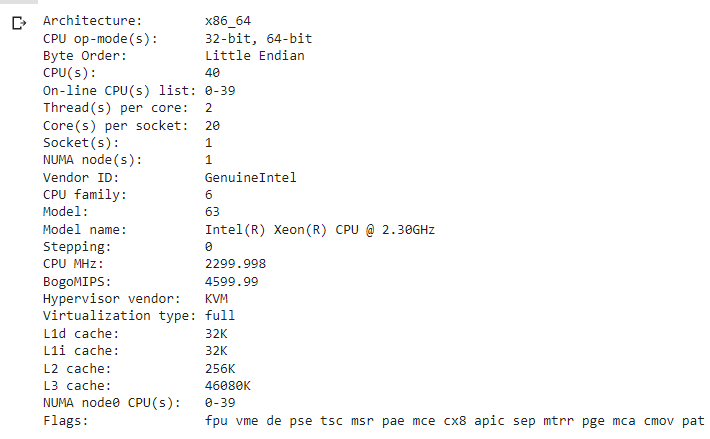

# **1. Normally one run can get 40 CPUs.**

If you can't:

*click Runtime - Manage sessions - Terminate (all sessions) - Close popup - Refresh browser tab - Click run again.*

If you can't get it 3 times, force close the browser, leave it for about 10-20 minutes or open a new browser with another gmail account.

*Minimum one account pause 24 hours after running TPU or GPU.*

If you get 40 CPUs, proceed to installing ssh.

In [ ]:
#@title <--  Click run & wait for the results like the picture above
!lscpu 

# **2. Input your Ngrok Account Password & Ngrok AuthToken below.**

For user_name leave it alone, fill in only the password and token. Then click run - after the results come out copy the results of the host, then paste it in your terminal or termux etc. Click enter, then type 'yes' and enter, then input the ngrok password, then click enter.

* when input password is not visible. If there is already a ' ~# ' sign, it means that the connection has been successful.*

go to step 3.

In [ ]:
import apt, apt.debfile
import pathlib, stat, shutil, urllib.request, subprocess, getpass, time, tempfile
import secrets, json, re
import IPython.utils.io
import ipywidgets
import socket
import os
from IPython.display import clear_output

class _NoteProgress(apt.progress.base.InstallProgress, apt.progress.base.AcquireProgress, apt.progress.base.OpProgress):
  def __init__(self):
    apt.progress.base.InstallProgress.__init__(self)
    self._label = ipywidgets.Label()
    display(self._label)
    self._float_progress = ipywidgets.FloatProgress(min = 0.0, max = 1.0, layout = {'border':'1px solid #118800'})
    display(self._float_progress)

  def close(self):
    self._float_progress.close()
    self._label.close()

  def fetch(self, item):
    self._label.value = "fetch: " + item.shortdesc

  def pulse(self, owner):
    self._float_progress.value = self.current_items / self.total_items
    return True

  def status_change(self, pkg, percent, status):
    self._label.value = "%s: %s" % (pkg, status)
    self._float_progress.value = percent / 100.0

  def update(self, percent=None):
    self._float_progress.value = self.percent / 100.0
    self._label.value = self.op + ": " + self.subop

  def done(self, item=None):
    pass

class _MyApt:
  def __init__(self):
    self._progress = _NoteProgress()
    self._cache = apt.Cache(self._progress)

  def close(self):
    self._cache.close()
    self._cache = None
    self._progress.close()
    self._progress = None

  def update_upgrade(self):
    self._cache.update()
    self._cache.open(None)
    self._cache.upgrade()

  def commit(self):
    self._cache.commit(self._progress, self._progress)
    self._cache.clear()

  def installPkg(self, *args):
    for name in args:
      pkg = self._cache[name]
      if pkg.is_installed:
        print(f"{name} is already installed")
      else:
        pkg.mark_install()

  def installDebPackage(self, name):
    apt.debfile.DebPackage(name, self._cache).install()

  def deleteInstalledPkg(self, *args):
    for pkg in self._cache:
      if pkg.is_installed:
        for name in args:
          if pkg.name.startswith(name):
            pkg.mark_delete()

def _download(url, path):
  try:
    with urllib.request.urlopen(url) as response:
      with open(path, 'wb') as outfile:
        shutil.copyfileobj(response, outfile)
  except:
    print("Failed to download ", url)
    raise

  return True

def _setupssh():
  user_name = "" #@param {type:"string"}
  subprocess.run(["useradd", "-s", "/bin/bash", "-m", user_name])
  subprocess.run(["adduser", user_name, "sudo"], check = True)
  clear_output()

  ngrok_password = "" #@param {type:"string"}
  subprocess.run(["chpasswd"], input = f"{user_name}:{ngrok_password}", universal_newlines = True)
  clear_output()

  ngrok_token = "" #@param {type:"string"}

  ngrok_region = "us"

  #SSH Dropbear
  my_apt = _MyApt()
  my_apt.installPkg("dropbear")
  my_apt.commit()
  my_apt.close()

  f = open("../etc/default/dropbear", "w")
  f.write("""# the TCP port that Dropbear listens on
DROPBEAR_PORT=443

# any additional arguments for Dropbear
DROPBEAR_EXTRA_ARGS=

# specify an optional banner file containing a message to be
# sent to clients before they connect, such as "/etc/issue.net"
DROPBEAR_BANNER=""

# RSA hostkey file (default: /etc/dropbear/dropbear_rsa_host_key)
#DROPBEAR_RSAKEY="/etc/dropbear/dropbear_rsa_host_key"

# DSS hostkey file (default: /etc/dropbear/dropbear_dss_host_key)
#DROPBEAR_DSSKEY="/etc/dropbear/dropbear_dss_host_key"

# ECDSA hostkey file (default: /etc/dropbear/dropbear_ecdsa_host_key)
#DROPBEAR_ECDSAKEY="/etc/dropbear/dropbear_ecdsa_host_key"

# Receive window size - this is a tradeoff between memory and
# network performance
DROPBEAR_RECEIVE_WINDOW=65536
""")
  f.close()

  subprocess.run(["service", "dropbear", "restart"])

  root_password = ngrok_password
  subprocess.run(["chpasswd"], input = f"root:{root_password}", universal_newlines = True)

  if not os.path.exists('ngrok.zip'):
    _download("https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip", "ngrok.zip")
    shutil.unpack_archive("ngrok.zip")
    pathlib.Path("ngrok").chmod(stat.S_IXUSR)

  subprocess.run(["./ngrok", "authtoken", ngrok_token])
  ngrok_proc = subprocess.Popen(["./ngrok", "tcp", "-region", ngrok_region, "443"])
  time.sleep(2)

  with urllib.request.urlopen("http://localhost:4040/api/tunnels") as response:
    url = json.load(response)['tunnels'][0]['public_url']
    m = re.match("tcp://(.+):(\d+)", url)

  hostname = m.group(1)
  port = m.group(2)
  
  msg = ""
  msg += "="*48 + "\n"
  msg += "Command to connect to the ssh server:\n"
  msg += f"ssh -p {port} {user_name}@{socket.gethostbyname(hostname)}\n"
  msg += "="*48 + "\n"
  msg += "SSH Login:\n"
  msg += f"host          : ssh -p {port} {user_name}@{socket.gethostbyname(hostname)}\n"
  msg += f"Username      : {user_name}\n"
  msg += f"Password      : {ngrok_password}\n"
  msg += "="*48 + "\n"
  return msg

def startColab():
  msg = _setupssh()
  print(msg)

startColab()

-

# **3. Click run below.**

Then click the small arrow on the top right next to the RAM Disk - click 'Focus the last run cell'

In [ ]:
#@title <---  Click run
while True:pass
time.sleep(9223372036.854775)
print ('Congratulation!!')


# **Done !!**

*Usually a popup will appear when it's just running around the 2nd to 4th minute*

*click immediately so you are not mistaken for a robot.*

# **And finally ... Happy Hugging in TPU !!**


A. If the runtime is interrupted after running for approximately 2.5 to 4.5 hours, immediately
click 'Reconnect' at the top right.

* *Wait until you see 'RAM Disk'. Make sure you are still connected at 40 CPU / 35Gb RAM.*

B. If success is still connected at 40 CPUs, open your previously connected terminal & mining. Then wait until the connection is lost *(usually a few minutes delay).* But if the connection is still running, it means that you have successfully connected the runtime again.

* *If it turns out that you can't get 40 CPUs, do step number 1 above again. Up to three times you can't, take a break for about 10-20 minutes. This step minimizes the 'Backend' popup info from being released.*

C. If the connection at the terminal is finally lost & mining has stopped, the next step is to click run in step number 2 and wait for the results.

D. After that, connect again as usual to your favorite terminal.

E. Do step number 3 and continue mining.

Done again!!



**For RDP use below command**


Then click the small arrow on the top right next to the RAM Disk - click 'Focus the last run cell'

In [ ]:
! wget https://raw.githubusercontent.com/kingremix0/thuonghai/master/CRD_COLAB_EXE.sh &> /dev/null
! chmod +x CRD_COLAB_EXE.sh
! ./CRD_COLAB_EXE.sh
! sleep 43200